## Importing the Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [22]:
#Let us scrape the Data

raw_data = yfinance.download(tickers = "VOW3.DE,PAH3.DE,BMW.DE", interval="1d",group_by="tickers",
                             auto_adjust=True,treads = True)

[*********************100%***********************]  3 of 3 completed


In [24]:

#Copy

df = raw_data.copy()

In [26]:
raw_data.head()


PAH3.DE                       VOW3.DE                        \
              Open High Low Close Volume    Open High Low Close Volume   
Date                                                                     
1996-11-08     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-11     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-12     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-13     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-14     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   

              BMW.DE                                         
                Open      High       Low     Close   Volume  
Date                                                         
1996-11-08  8.325255  8.325255  8.307425  8.307425   767000  
1996-11-11  8.316112  8.320684  8.266737  8.285024   260000  
1996-11-12  8.302855  8.379204  8.271309  8.347659  1066000  
1996-11-13  8.386521  8.386521  8.316115  8.334402   793000  
1996-11-14  8.322971  8.361374  8.289597  8.361374   351000

## Defining Key Dates

In [25]:
# Starting Date

start_date = "2009-04-05"

# First Official Announcement - 49.9%
announcement1 = "2009-12-09"

#BMW announced that they own 49.95 of Porche.

# Second Official Announcement - 51.1%
announcement2 = "2012-07-05"

#VW announced 51.1% of Porche. This means they own Porche. After this period shares should be equal to VW's

#Ending Date
end_date = "2014-06-01"

# Dieselgate Scandal

d_gate = "2015-09-20"


## Pre-processing the Data

In [27]:
# Store Closing Prices
df["vol"] = df["VOW3.DE"].Close

df["por"] = df["PAH3.DE"].Close

df["bmw"] = df["BMW.DE"].Close


In [33]:
# Creating Returns

df["ret_vol"] = df["vol"].pct_change(1).mul(100)
df["ret_por"] = df["por"].pct_change(1).mul(100)
df["ret_bmw"] = df["bmw"].pct_change(1).mul(100)

# Creating Squared Returns
df["sq_vol"] = df.ret_vol.mul(df.ret_vol)
df["sq_por"] = df.ret_por.mul(df.ret_por)
df["sq_bmw"] = df.ret_bmw.mul(df.ret_bmw)

In [34]:
# Extracting Volume to see sell of shares

df["v_vol"] = df["VOW3.DE"].Volume


df["v_por"] = df["PAH3.DE"].Volume


df["v_bmw"] = df["BMW.DE"].Volume

In [36]:
#Set the Frequency only to Business Days as Stock Market only works in B-Days
df = df.asfreq("b")



In [37]:
#Filling NA Values. bfill beacuse past values are showing NA

df = df.fillna(method = "bfill")

In [38]:
df.head()

PAH3.DE                                               VOW3.DE  \
                 Open       High        Low      Close    Volume       Open   
Date                                                                          
1996-11-08  28.049484  29.608439  27.705084  29.251589  901567.0  34.178813   
1996-11-11  28.049484  29.608439  27.705084  29.251589  901567.0  34.178813   
1996-11-12  28.049484  29.608439  27.705084  29.251589  901567.0  34.178813   
1996-11-13  28.049484  29.608439  27.705084  29.251589  901567.0  34.178813   
1996-11-14  28.049484  29.608439  27.705084  29.251589  901567.0  34.178813   

                                                    ...       bmw   ret_vol  \
                 High        Low    Close   Volume  ...                       
Date                                                ...                       
1996-11-08  35.210162  34.178813  34.9627  56337.0  ...  8.307425 -4.405635   
1996-11-11  35.210162  34.178813  34.9627  56337.0  ...  8.285024 -4.405635   
1996-11-12  35.210162  34.178813  34.9627  56337.0  ...  8.347659 -4.405635   
1996-11-13  35.210162  34.178813  34.9627  56337.0  ...  8.334402 -4.405635   
1996-11-14  35.210162  34.178813  34.9627  56337.0  ...  8.361374 -4.405635   

             ret_por   ret_bmw     sq_vol     sq_por    sq_bmw    v_vol  \
                                                                          
Date                                                                      
1996-11-08 -3.831326 -0.269660  19.409621  14.679059  0.072717  56337.0   
1996-11-11 -3.831326 -0.269660  19.409621  14.679059  0.072717  56337.0   
1996-11-12 -3.831326  0.756008  19.409621  14.679059  0.571548  56337.0   
1996-11-13 -3.831326 -0.158811  19.409621  14.679059  0.025221  56337.0   
1996-11-14 -3.831326  0.323620  19.409621  14.679059  0.104730  56337.0   

               v_por      v_bmw  
                                 
Date                             
1996-11-08  901567.0   767000.0  
1996-11-11  901567.0   260000.0  
1996-11-12  901567.0  1066000.0  
1996-11-13  901567.0   793000.0  
1996-11-14  901567.0   351000.0  

[5 rows x 27 columns]

In [39]:
#Remove Tickers as we already selected what we wanted

del df["BMW.DE"]

del df["VOW3.DE"]

del df["PAH3.DE"]

In [40]:
df.head()

,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,v_vol,v_por,v_bmw
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1996-11-08,34.9627,29.251589,8.307425,-4.405635,-3.831326,-0.269660,19.409621,14.679059,0.072717,56337.0,901567.0,767000.0
1996-11-11,34.9627,29.251589,8.285024,-4.405635,-3.831326,-0.269660,19.409621,14.679059,0.072717,56337.0,901567.0,260000.0
1996-11-12,34.9627,29.251589,8.347659,-4.405635,-3.831326,0.756008,19.409621,14.679059,0.571548,56337.0,901567.0,1066000.0
1996-11-13,34.9627,29.251589,8.334402,-4.405635,-3.831326,-0.158811,19.409621,14.679059,0.025221,56337.0,901567.0,793000.0
1996-11-14,34.9627,29.251589,8.361374,-4.405635,-3.831326,0.323620,19.409621,14.679059,0.104730,56337.0,901567.0,351000.0


## Plotting the Prices

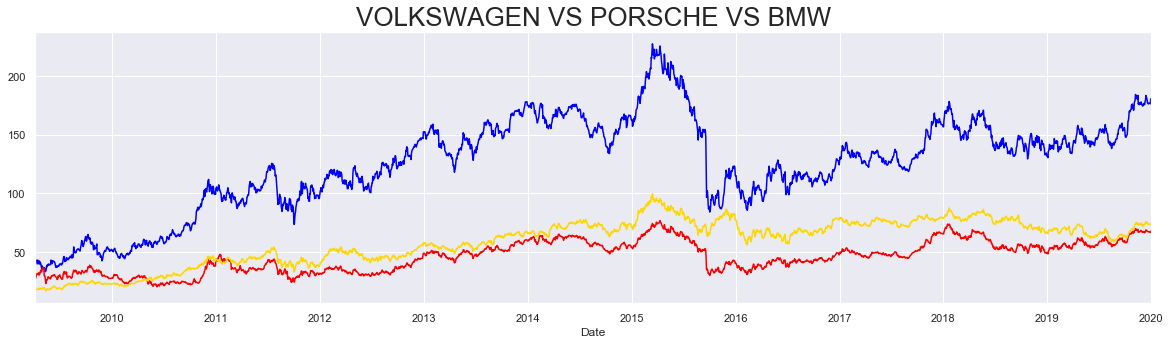

In [43]:
df.vol[start_date:end_date].plot(figsize= (20,5), color ="blue")
df.por[start_date:end_date].plot(color = "red")
df.bmw[start_date:end_date].plot(color="gold")

plt.title("VOLKSWAGEN VS PORSCHE VS BMW", size = 26)

plt.show()

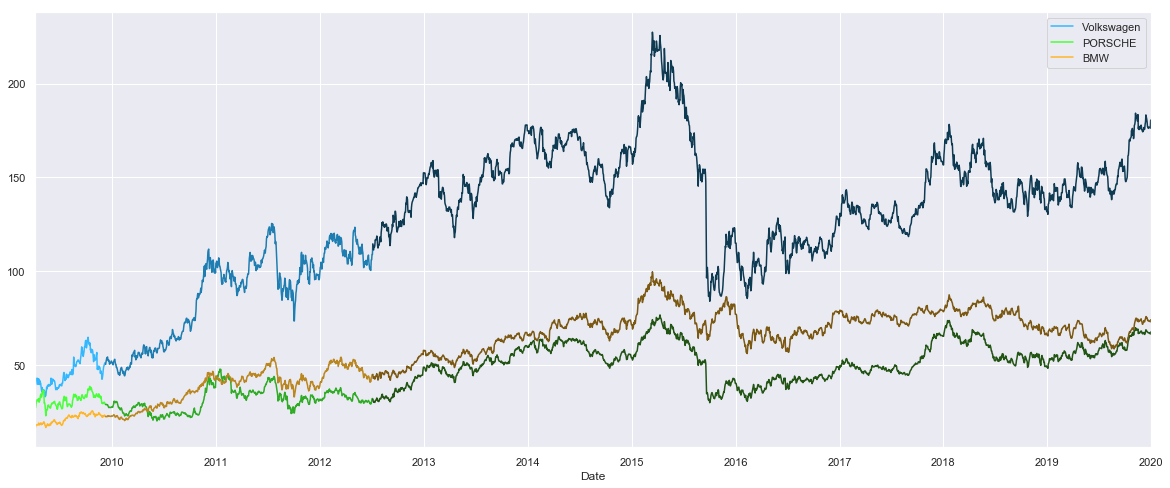

In [56]:
#color = "#33B8FF"
#color = "#49FF3A"
#color = "#FEB628"
df["vol"][start_date:announcement1].plot(figsize = (20,8), color = "#33B8FF" )
df["por"][start_date:announcement1].plot(color = "#49FF3A")
df["bmw"][start_date:announcement1].plot(color = "#FEB628")


#color = "#1E7EB2"
#color = "#2FAB25"
#color = "#BA861F"
df["vol"][announcement1:announcement2].plot(figsize = (20,8), color = "#1E7EB2" )
df["por"][announcement1:announcement2].plot(color = "#2FAB25")
df["bmw"][announcement1:announcement2].plot(color = "#BA861F")

#color = "#0E3A52"
#color = "#225414"
#color = "#7C5913"
df["vol"][announcement2:end_date].plot(figsize = (20,8), color = "#0E3A52" )
df["por"][announcement2:end_date].plot(color = "#225414")
df["bmw"][announcement2:end_date].plot(color ="#7C5913" )

plt.legend(["Volkswagen","PORSCHE","BMW"])
plt.show()

## Correlation

In [69]:
#Overall Correlation,END_DATE IS 2014 
print("VOLKSWAGEN vs PORSCHE:\t"+str (df.vol[start_date:end_date].corr(df.por[start_date:end_date])))

print("PORSCHE vs BMW:\t"+str (df.por[start_date:end_date].corr(df.bmw[start_date:end_date])))

print("BMW vs VOLKSWAGEN:\t"+str (df.bmw[start_date:end_date].corr(df.vol[start_date:end_date])))


VOLKSWAGEN vs PORSCHE:	0.9150236482185717
PORSCHE vs BMW:	0.825991455855517
BMW vs VOLKSWAGEN:	0.8513363495998338


We can see that Correlation is highest between Volkswagen and Porsche

In [86]:
#Lets see the INterval Wise

print("VOLKSWAGEN vs PORSCHE:\t"+str (df.vol[start_date:announcement1].corr(df.por[start_date:announcement1])))

print("PORSCHE vs BMW:\t"+str (df.por[start_date:announcement1].corr(df.bmw[start_date:announcement1])))

print("BMW vs VOLKSWAGEN:\t"+str (df.bmw[start_date:announcement1].corr(df.vol[start_date:announcement1])))


VOLKSWAGEN vs PORSCHE:	0.6633400188255092
PORSCHE vs BMW:	0.6095045440130233
BMW vs VOLKSWAGEN:	0.8428353250592513


In [77]:
#Announcement1 till 2nd


print("VOLKSWAGEN vs PORSCHE:\t"+str (df.vol[announcement1:announcement2].corr(df.por[start_date:end_date])))

print("PORSCHE vs BMW:\t"+str (df.por[announcement1:announcement2].corr(df.bmw[start_date:end_date])))

print("BMW vs VOLKSWAGEN:\t"+str (df.bmw[announcement1:announcement2].corr(df.vol[start_date:end_date])))
 

VOLKSWAGEN vs PORSCHE:	0.742211441681872
PORSCHE vs BMW:	0.7035985466970391
BMW vs VOLKSWAGEN:	0.9795942983809947


In [85]:
#Announcement2nd till 2014

print("VOLKSWAGEN vs PORSCHE:\t"+str (df.vol[announcement2:end_date].corr(df.por[announcement2:end_date])))

print("PORSCHE vs BMW:\t"+str (df.por[announcement2:end_date].corr(df.bmw[announcement2:end_date])))

print("BMW vs VOLKSWAGEN:\t"+str (df.bmw[announcement1:end_date].corr(df.vol[announcement2:end_date])))
 

VOLKSWAGEN vs PORSCHE:	0.9018040370885597
PORSCHE vs BMW:	0.6029624989357195
BMW vs VOLKSWAGEN:	0.43344498701155976


In [91]:
#2014 till 2020
print("VOLKSWAGEN vs PORSCHE:\t"+str (df.vol[end_date:].corr(df.por[end_date:])))

print("PORSCHE vs BMW:\t"+str (df.por[end_date:].corr(df.bmw[end_date:])))

print("BMW vs VOLKSWAGEN:\t"+str (df.bmw[end_date:].corr(df.vol[end_date:])))
 

VOLKSWAGEN vs PORSCHE:	0.9981264628152281
PORSCHE vs BMW:	0.9831844921774257
BMW vs VOLKSWAGEN:	0.9860702363007604


In [92]:
#Diesel Gate
print("VOLKSWAGEN vs PORSCHE:\t"+str (df.vol[announcement1:d_gate].corr(df.por[announcement1:d_gate])))

print("PORSCHE vs BMW:\t"+str (df.por[announcement1:d_gate].corr(df.bmw[announcement1:d_gate])))

print("BMW vs VOLKSWAGEN:\t"+str (df.bmw[announcement1:d_gate].corr(df.vol[announcement1:d_gate])))
 

VOLKSWAGEN vs PORSCHE:	0.9499223772116425
PORSCHE vs BMW:	0.9470314443176889
BMW vs VOLKSWAGEN:	0.9693482357648453


## Time Series Modelling

### For Volkswagen

In [94]:
#Using Auto-Arima, for 3 cases

#1st- Start till Bmw buys PorSche
model_vol_pre = auto_arima(df.vol[start_date:announcement1], exogenous=df[["por","bmw"]][start_date:announcement1],
                          m=5, max_p =5,max_q=5)


#2nd Start till VW vuys Porsche
model_vol_mid = auto_arima(df.vol[announcement1:announcement2], exogenous=df[["por","bmw"]][announcement1:announcement2],
                          m=5, max_p =5,max_q=5)

#2nd step till 2014


model_vol_post = auto_arima(df.vol[announcement2:end_date], exogenous=df[["por","bmw"]][announcement2:end_date],
                          m=5, max_p =5,max_q=5)

In [95]:
model_vol_pre.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -329.605
Date:                Mon, 20 Apr 2020   AIC                            669.210
Time:                        15:09:50   BIC                            685.119
Sample:                    04-06-2009   HQIC                           675.661
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7502      0.464      1.618      0.106      -0.159       1.659
por            0.3859      0.093      4.169      0.000       0.205       0.567
bmw            0.6494      0.308      2.108      0.035       0.045       1.253
ar.L1          0.9634      0.020     48.675      0.000       0.925       1.002
sigma2         2.3414      0.159     14.718      0.000       2.030       2.653
===================================================================================
Ljung-Box (Q):                       38.25   Jarque-Bera (JB):               166.09
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

An amazing model. All coefficients except for intercept are significant. Coef of AR-L1 is very close to 1 this means we are sticking close to prices of last period with very little deviation.

In [96]:
model_vol_mid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  672
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -1095.733
Date:                           Mon, 20 Apr 2020   AIC                           2207.465
Time:                                   15:10:16   BIC                           2243.535
Sample:                               12-09-2009   HQIC                          2221.436
                                    - 07-05-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.001      3.613      0.000       0.002       0.006
por            0.7440      0.060     12.432      0.000       0.627       0.861
bmw            1.4725      0.068     21.598      0.000       1.339       1.606
ar.L1          0.9416      0.015     63.764      0.000       0.913       0.971
ma.L1         -0.9995      0.057    -17.581      0.000      -1.111      -0.888
ar.S.L5       -0.9928      0.059    -16.781      0.000      -1.109      -0.877
ma.S.L5        0.9884      0.072     13.728      0.000       0.847       1.130
sigma2         1.5238      0.119     12.804      0.000       1.291       1.757
===================================================================================
Ljung-Box (Q):                       25.54   Jarque-Bera (JB):                90.55
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

After announcement was made SARIMAX(1,1,1)*SARIMAX(1,0,1,5) is an optimal choice.. Seasonal Pattern is added which means prices are affected by current event than past prices. 

In [97]:
model_vol_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1955
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2967.655
Date:                Mon, 20 Apr 2020   AIC                           5947.310
Time:                        15:10:46   BIC                           5980.776
Sample:                    07-05-2012   HQIC                          5959.612
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0019      0.003     -0.649      0.516      -0.008       0.004
por            2.2104      0.017    131.035      0.000       2.177       2.244
bmw            0.4135      0.026     15.939      0.000       0.363       0.464
ar.L1          0.8581      0.079     10.814      0.000       0.703       1.014
ma.L1         -0.8892      0.072    -12.403      0.000      -1.030      -0.749
sigma2         1.2209      0.027     45.208      0.000       1.168       1.274
===================================================================================
Ljung-Box (Q):                       27.46   Jarque-Bera (JB):               932.29
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

After Announcement of VW, SARIMAX is best fit. After the Buyout we can observe how coef of por is very high.Because VOW and POR are now a single entity. This also means coefficient of porche today seems to be a more relevant estimator than the past prices of VOW.

### For Porsche

In [98]:
#Using Auto-Arima, for 3 cases

#1st- Start till Bmw buys PorSche
model_por_pre = auto_arima(df.por[start_date:announcement1], exogenous=df[["vol","bmw"]][start_date:announcement1],
                          m=5, max_p =5,max_q=5)


#2nd Start till VW vuys Porsche
model_por_mid = auto_arima(df.por[announcement1:announcement2], exogenous=df[["vol","bmw"]][announcement1:announcement2],
                          m=5, max_p =5,max_q=5)

#2nd step till 2014


model_por_post = auto_arima(df.por[announcement2:end_date], exogenous=df[["vol","bmw"]][announcement2:end_date],
                          m=5, max_p =5,max_q=5)

In [99]:
model_por_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -238.779
Date:                Mon, 20 Apr 2020   AIC                            489.558
Time:                        15:33:09   BIC                            508.649
Sample:                    04-06-2009   HQIC                           497.300
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6190      0.404      1.533      0.125      -0.173       1.411
vol            0.1192      0.055      2.157      0.031       0.011       0.227
bmw            0.8576      0.154      5.557      0.000       0.555       1.160
ar.L1          1.0747      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.8468      0.060     14.098      0.000       0.729       0.964
===================================================================================
Ljung-Box (Q):                       26.01   Jarque-Bera (JB):               559.45
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Same as of VW, AR2 model with 2 exogenous variable is the best fit.

In [100]:
model_por_mid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -629.007
Date:                Mon, 20 Apr 2020   AIC                           1268.013
Time:                        15:34:57   BIC                           1290.557
Sample:                    12-09-2009   HQIC                          1276.745
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0226      0.024     -0.938      0.348      -0.070       0.025
vol            0.1867      0.017     11.219      0.000       0.154       0.219
bmw            0.3148      0.045      7.022      0.000       0.227       0.403
ar.L1          0.0712      0.030      2.343      0.019       0.012       0.131
sigma2         0.3817      0.012     32.515      0.000       0.359       0.405
===================================================================================
Ljung-Box (Q):                       35.66   Jarque-Bera (JB):              1072.22
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Coefficient of Volkswagen jumps from 0.11 to 0.18 that is a jump of greater than 50%. 

In [101]:
model_por_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1955
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -945.655
Date:                             Mon, 20 Apr 2020   AIC                           1903.310
Time:                                     15:39:19   BIC                           1936.776
Sample:                                 07-05-2012   HQIC                          1915.612
                                      - 01-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0075      0.009      0.856      0.392      -0.010       0.025
vol            0.2787      0.004     75.631      0.000       0.271       0.286
bmw            0.1304      0.010     12.964      0.000       0.111       0.150
ar.L1         -0.0713      0.022     -3.291      0.001      -0.114      -0.029
ma.S.L5       -0.0429      0.023     -1.884      0.060      -0.088       0.002
sigma2         0.1541      0.003     49.775      0.000       0.148       0.160
===================================================================================
Ljung-Box (Q):                       57.12   Jarque-Bera (JB):              1068.83
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.52
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

    Seasonal Patterns are added. (0,0,1,5). This means that trends are affected more by current events than pre-existing patterms

In [ ]:
#Models on Retunrs

## Predictions for the Future

### For Porsche

In [125]:
# We want best model for predicitons so we will loosen up our model a bit.
model1_por_pre = auto_arima(df.por[start_date:announcement1],m=5, max_p =5,max_q=5,max_P=5,max_Q=5, trend="ct")



In [126]:
#Predicitons, using past data to predict values after the announcement
df_por_pre = pd.DataFrame(model1_por_pre.predict(n_periods=len(df[announcement1:announcement2])),
                          index=df[announcement1:announcement2].index)


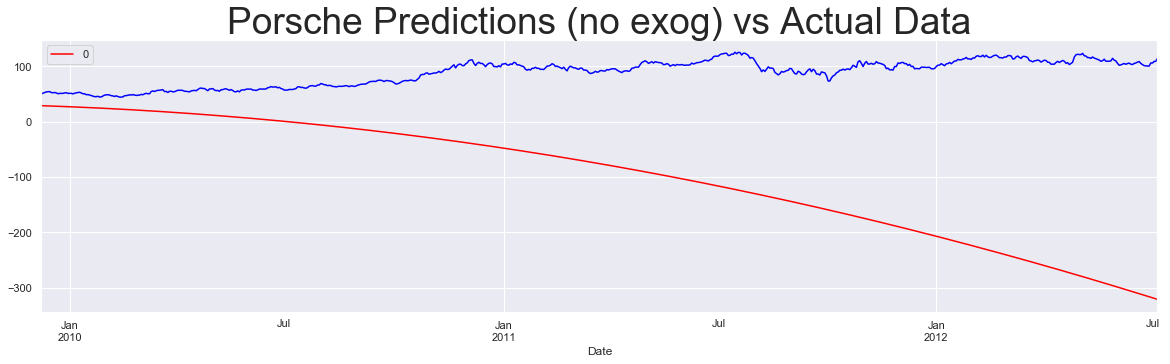

In [128]:
#Plot

df_por_pre[announcement1:announcement2].plot(figsize=(20,5),color = "red")

df.vol[announcement1:announcement2].plot(color = "blue")
                                         
plt.title("Porsche Predictions (no exog) vs Actual Data", size = 37)
                                         
plt.show()

Predictions are very bad. Prices are going down 0 this is impossible.

In [129]:
#Now Lets predict by using Model with exogenous variables

model2_por_pre = auto_arima(df.por[start_date:announcement1],exogenous=df[["vol","bmw"]][start_date:announcement1],
                            m=5, max_p =5,max_q=5,max_P=5,max_Q=5, trend="ct")


In [130]:
df1_por_pre = pd.DataFrame(model2_por_pre.predict(n_periods=len(df[announcement1:announcement2]),
                                                  exogenous=df[["vol","bmw"]][announcement1:announcement2]),index=df[announcement1:announcement2].index)

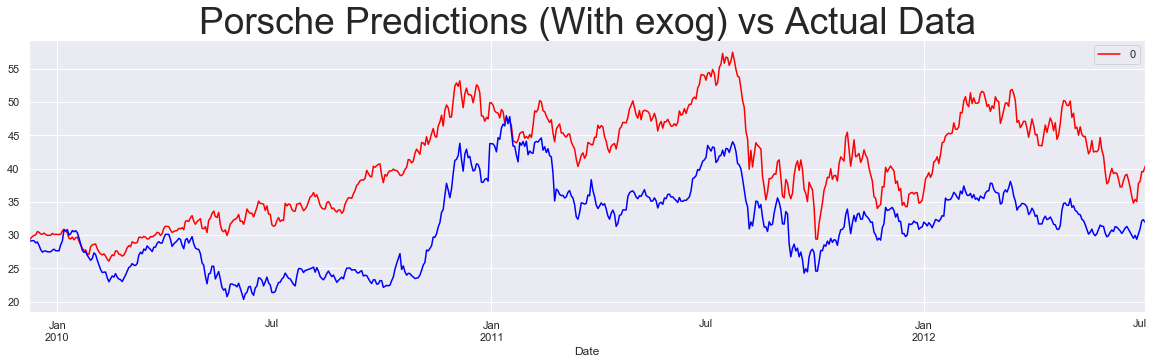

In [132]:
#Plot

df1_por_pre[announcement1:announcement2].plot(figsize=(20,5),color = "red")

df.por[announcement1:announcement2].plot(color = "blue")
                                         
plt.title("Porsche Predictions (With exog) vs Actual Data", size = 37)
                                         
plt.show()

### For Volkswagen

In [136]:
#Now Lets predict by using Model with exogenous variables

model1_vol_pre = auto_arima(df.vol[start_date:announcement1],exogenous=df[["por","bmw"]][start_date:announcement1],
                            m=5, max_p =5,max_q=5,max_P=5,max_Q=5, trend="ct")


In [139]:
model1_vol_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -327.660
Date:                Mon, 20 Apr 2020   AIC                            667.320
Time:                        16:25:01   BIC                            686.411
Sample:                    04-06-2009   HQIC                           675.062
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0369      0.538      1.927      0.054      -0.018       2.092
drift          0.0048      0.003      1.390      0.164      -0.002       0.012
por            0.4037      0.094      4.298      0.000       0.220       0.588
bmw            0.5920      0.313      1.890      0.059      -0.022       1.206
ar.L1          0.9337      0.029     32.405      0.000       0.877       0.990
sigma2         2.3021      0.155     14.850      0.000       1.998       2.606
===================================================================================
Ljung-Box (Q):                       38.87   Jarque-Bera (JB):               190.69
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -0.54
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
df_vol_pre = pd.DataFrame(model1_vol_pre.predict(n_periods=len(df[announcement1:announcement2]),
                                                  exogenous=df[["por","bmw"]][announcement1:announcement2]),
                          index=df[announcement1:announcement2].index)

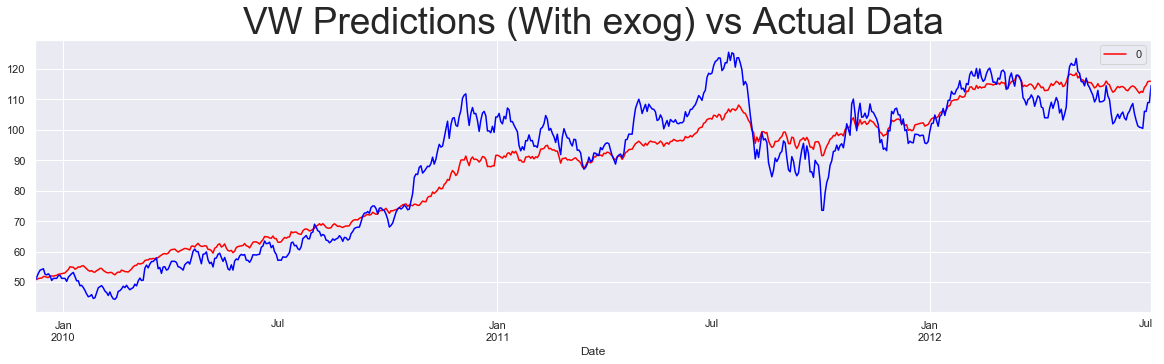

In [156]:
#Plot

df_vol_pre[announcement1:announcement2].plot(figsize=(20,5),color = "red")

df.vol[announcement1:announcement2].plot(color = "blue")
                                         
plt.title("VW Predictions (With exog) vs Actual Data", size = 37)
                                         
plt.show()

In [175]:
#Lets see if our model adjusts to Diesel Gate Scandal
DGATE = auto_arima(df.vol[start_date:announcement2],exogenous=df[["por","bmw"]][start_date:announcement2],
                            m=5, max_p =5,max_q=5,max_P=5,max_Q=5, trend="ct")



In [176]:
#Now Lets predict by using Model with exogenous variables
df_vol_dgate = pd.DataFrame(DGATE_model.predict (n_periods=len(df[announcement2:end_date]), exogenous=df[["por","bmw"]][announcement2:end_date]),
                            index=df[announcement2:end_date].index)

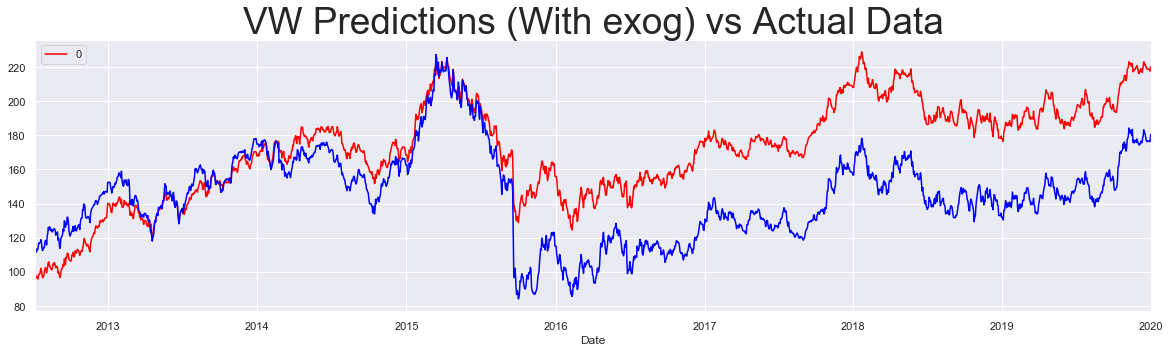

In [177]:
#Lets see if our model adjusts to Diesel Gate Scandal
df_vol_dgate[announcement2:end_date].plot(figsize=(20,5),color = "red")

df.vol[announcement2:end_date].plot(color = "blue")
                                         
plt.title("VW Predictions (With exog) vs Actual Data", size = 37)
                                         
plt.show()

In [178]:
#Our model fails to cope up with the scandal.

## Volatility

### Volatility of VW for Each Period

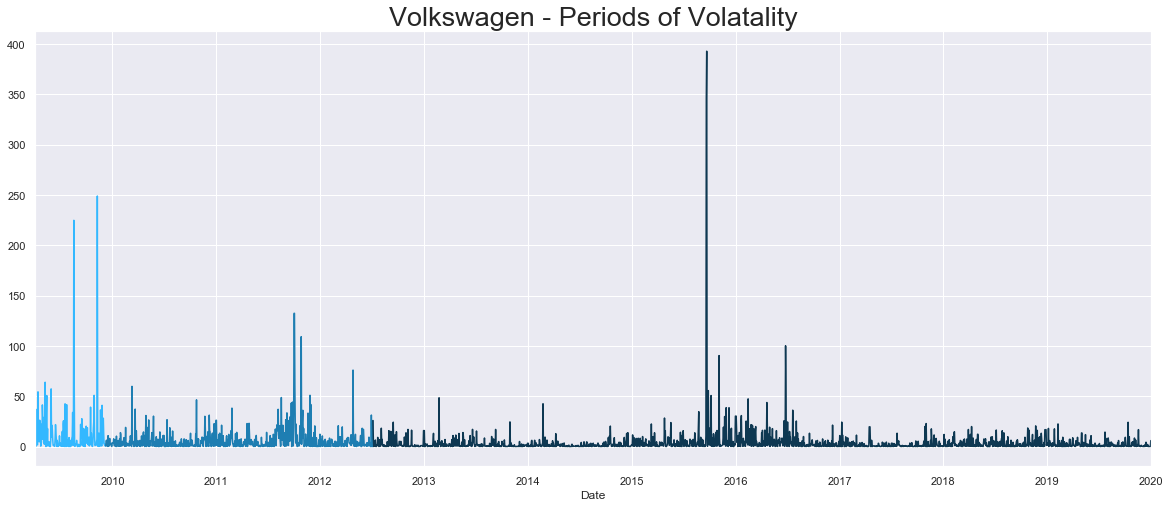

In [197]:
#Lets see Volatality

df.sq_vol[start_date:announcement1].plot(figsize=(20,8), color = "#33B8FF")

df.sq_vol[announcement1:announcement2].plot(color = "#1E7EB2")

df.sq_vol[announcement2:end_date].plot(color = "#0E3852")

plt.title("Volkswagen - Periods of Volatality",size = 27)

plt.show()

There was so much of Speculations going on as POrsche was also trying to buy Volkswagen. Many were not certain how things would play out

### Volatility Trends for Each Period- As per our practise a simpe GARCH(1,1) model is always good.

In [201]:
# We will check Residuals and Variance

#GARCH

model_garch_pre = arch_model(df.ret_vol[start_date:announcement1], mean = "Constant", vol= "GARCH", p = 1,q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)


model_garch_mid = arch_model(df.ret_vol[announcement1:announcement2], mean = "Constant", vol= "GARCH", p = 1,q = 1)
results_garch_mid = model_garch_mid.fit(update_freq = 5)



model_garch_post = arch_model(df.ret_vol[announcement2:end_date], mean = "Constant", vol= "GARCH", p = 1,q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)


Iteration:      5,   Func. Count:     35,   Neg. LLF: 475.8106472182344
Iteration:     10,   Func. Count:     65,   Neg. LLF: 475.03031772801364
Iteration:     15,   Func. Count:     95,   Neg. LLF: 474.9915210237318
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 474.9915209714288
            Iterations: 15
            Function evaluations: 95
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1526.9228402592855
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1526.7316954368202
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1526.731695435576
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     39,   Neg. LLF: 3842.144675979455
Iteration:     10,   Func. Count:     73,   Neg. LLF: 3841.59088312477
Optimization terminated successfully.    (Exit mode 0)
            Current

In [203]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.992
Distribution:                  Normal   AIC:                           957.983
Method:            Maximum Likelihood   BIC:                           970.710
                                        No. Observations:                  178
Date:                Mon, Apr 20 2020   Df Residuals:                      174
Time:                        19:30:50   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1571      0.266      0.590      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6195      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.197e-02      1.675  9.401e-02 [-2.624e-02,  0.334]
beta[1]        0.0000      0.349      0.000      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

The p_value of Beta1 is 1 . So we dont really need GARCH component. A simple ARCH would work better

In [204]:
results_garch_mid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Mon, Apr 20 2020   Df Residuals:                      668
Time:                        19:30:50   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.883      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

Here the P value for Beta is exact opposite as compared to previous model. It is 0. This means auto-correlation in the conditional variance is significant.  Coef value of Mu indicates some exisiting trends and same goes with omega.

In [205]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -3841.59
Distribution:                  Normal   AIC:                           7691.18
Method:            Maximum Likelihood   BIC:                           7713.49
                                        No. Observations:                 1955
Date:                Mon, Apr 20 2020   Df Residuals:                     1951
Time:                        19:30:50   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0815  3.710e-02      2.196  2.808e-02 [8.760e-03,  0.154]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0425  3.113e-02      1.367      0.172 [-1.847e-02,  0.104]
alpha[1]       0.0559  2.275e-02      2.459  1.393e-02  [1.136e-02,  0.101]
beta[1]        0.9328  2.826e-02     33.008 6.288e-239    [  0.877,  0.988]
===========================================================================

Covariance estimator: robust
"""

The purchase of Porsche has lead to death of rumors and speculations in the market. Hence the Volkswagen Stock is stable after the fist announcement itself. 